# GVSA Data Analysis

This notebook provides a starting point for analyzing GVSA soccer data. It includes:
- Database connection and schema exploration
- Basic statistics about the data
- Sample data from each table


In [1]:
# Import required libraries
import sys
from pathlib import Path

# Database and ORM
from pony.orm import db_session, select, count
from models import db, Season, Division, Team, TeamSeason, Match, Club
from db_pony import GVSA_Database

# Data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully")


Libraries imported successfully


## Connect to Database


In [2]:
# Connect to the database
db_path = "/projects/gvsa_scrape/gvsa_data2.db"

# Explicitly bind the database (required for Jupyter notebooks)
# This ensures the database is properly bound even if cells are run multiple times
try:
    # Unbind if already bound to a different database
    if hasattr(db, 'provider') and db.provider:
        db.disconnect()
except Exception:
    pass

# Bind to the database
db.bind(provider='sqlite', filename=db_path, create_db=False)
db.generate_mapping(create_tables=False)

# Initialize database connection (for compatibility)
gvsa_db = GVSA_Database(db_path)

print(f"Connected to database: {db_path}")
print(f"Database file exists: {Path(db_path).exists()}")

# Verify connection by checking if we can access the database
with db_session:
    season_count = count(s for s in Season)
    print(f"Seasons in database: {season_count}")


Connected to database: /projects/gvsa_scrape/gvsa_data2.db
Database file exists: True
Seasons in database: 71


## Database Schema

The database contains the following entities:
- **Season**: Soccer seasons (Fall/Spring)
- **Division**: Divisions within seasons (e.g., "U11 Boys 5th Division")
- **Club**: Soccer clubs (e.g., "NUSC", "Rapids FC")
- **Team**: Team entities that persist across seasons
- **TeamSeason**: Team participation in specific division/season with statistics
- **Match**: Soccer matches with scores and scheduling


In [3]:
# Display database schema information
with db_session:
    print("Database Schema:")
    print("=" * 60)
    
    # Get counts for each entity
    stats = {
        'Seasons': count(s for s in Season),
        'Divisions': count(d for d in Division),
        'Clubs': count(c for c in Club),
        'Teams': count(t for t in Team),
        'Team Seasons': count(ts for ts in TeamSeason),
        'Matches': count(m for m in Match),
    }
    
    for entity, count_val in stats.items():
        print(f"{entity:20s}: {count_val:>8,}")
    
    print("=" * 60)


Database Schema:
Seasons             :       71
Divisions           :    1,606
Clubs               :      766
Teams               :    1,261
Team Seasons        :   12,096
Matches             :        0


## Sample Data

Let's look at sample data from each table:


In [ ]:
# Sample Seasons
with db_session:
    print("Sample Seasons:")
    print("-" * 60)
    seasons = select(s for s in Season).order_by(Season.scraped_at.desc()).limit(5)
    for season in seasons:
        # Display just the season_name (e.g., "Fall 2025")
        print(f"  {season.season_name} ({season.season_type})")
    print()


Sample Seasons:
------------------------------------------------------------
  Fall 2020 (2020/2021) - F
  Fall 2020 (2020/2021) - F
  Fall 2020 (2020/2021) - F
  Spring 2021 (2020/2021) - F
  Spring 2021 (2020/2021) - F



In [5]:
# Sample Divisions
with db_session:
    print("Sample Divisions:")
    print("-" * 60)
    divisions = select(d for d in Division).order_by(Division.division_name).limit(10)
    for div in divisions:
        print(f"  {div.division_name} - {div.season.season_name}")
    print()


Sample Divisions:
------------------------------------------------------------
  Gazelle Sports U12 Boys Elite - Fall 2012
  Gazelle Sports U12 Boys Elite - Spring 2013
  Gazelle Sports U12 Girls Elite - Fall 2012
  Gazelle Sports U12 Girls Elite - Spring 2013
  Gazelle Sports U13 Boys Elite - Fall 2012
  Gazelle Sports U13 Boys Elite - Spring 2013
  Gazelle Sports U13 Girls Elite - Spring 2013
  Gazelle Sports U14 Boys Elite - Fall 2012
  Gazelle Sports U14 Boys Elite - Spring 2013
  Gazelle Sports U14 Girls Elite - Fall 2012



In [6]:
# Sample Clubs
with db_session:
    print("Sample Clubs:")
    print("-" * 60)
    clubs = select(c for c in Club).order_by(Club.name)
    for club in clubs:
        team_count = count(t for t in Team if t.club == club)
        print(f"  {club.name} ({team_count} teams)")
    print()


Sample Clubs:
------------------------------------------------------------
  "OLE SOCCER OLE SC "" BOYS" (1 teams)
  ' LASSO RASCALS (1 teams)
  / Miller - (1 teams)
  / Zwak - (1 teams)
  AGUILAS OF GRAND RAPIDS GALAXY (1 teams)
  AYSO United ADA HS Girls (1 teams)
  AYSO United Ada (3 teams)
  AYSO United BYR (4 teams)
  AYSO United BYR HS Girls (1 teams)
  AYSO United CAL (1 teams)
  AYSO United CED (1 teams)
  AYSO United GEO (4 teams)
  AYSO United GEO HS Girls (1 teams)
  AYSO United HS Boys (1 teams)
  AYSO United HS Girls Select (1 teams)
  Aguilas (1 teams)
  Aguilas / - (1 teams)
  Alliance / (1 teams)
  Alliance Academy (0 teams)
  Alliance Academy Kicks (1 teams)
  Alliance Academy Newaygo Co (1 teams)
  Alliance Boys (2 teams)
  Alliance FC (7 teams)
  Alliance FC / (1 teams)
  Alliance FC ALLIANCE (2 teams)
  Alliance FC ALLIANCE BOYS B (1 teams)
  Alliance FC ALLIANCE GIRLS (1 teams)
  Alliance FC BOYS (1 teams)
  Alliance FC GIRLS (1 teams)
  Alliance FC Orange (1 teams

In [7]:
# Sample Teams with Statistics
with db_session:
    print("Sample Team Seasons (with statistics):")
    print("-" * 60)
    team_seasons = select(ts for ts in TeamSeason).order_by(
        TeamSeason.points.desc()
    ).limit(10)
    
    for ts in team_seasons:
        print(f"  {ts.team_name}")
        print(f"    Division: {ts.division.division_name}")
        print(f"    Record: {ts.wins}W-{ts.losses}L-{ts.ties}T, {ts.points} pts")
        print(f"    Goals: {ts.goals_for}GF / {ts.goals_against}GA")
        print()


Sample Team Seasons (with statistics):
------------------------------------------------------------
  MI Rangers FC 15G Black
    Division: U10 Girls 2nd Division
    Record: 8W-0L-0T, 24 pts
    Goals: 41GF / 10GA

  NUSC U13 G Blue Stars
    Division: U13 Girls 2nd Division
    Record: 8W-0L-0T, 24 pts
    Goals: 17GF / 2GA

  Holland Rovers 2010B Red
    Division: U14 Boys Elite
    Record: 8W-0L-0T, 24 pts
    Goals: 30GF / 5GA

  AYSO United BYR 14G
    Division: U10 Girls 3rd Division
    Record: 8W-0L-0T, 24 pts
    Goals: 51GF / 4GA

  CASSA 13G
    Division: U11G 3rd Division
    Record: 8W-0L-0T, 24 pts
    Goals: 26GF / 4GA

  USA 15G Red
    Division: U9 Girls 2nd Division
    Record: 8W-0L-0T, 24 pts
    Goals: 28GF / 3GA

  Holland Rovers Eagles 2010G
    Division: U14 Girls Elite
    Record: 8W-0L-0T, 24 pts
    Goals: 34GF / 4GA

  MFA Revolution NS 15B Black
    Division: U9 Boys 3rd Division
    Record: 8W-0L-0T, 24 pts
    Goals: 67GF / 10GA

  MFA Revolution SS 13B 

In [8]:
# Sample Matches
with db_session:
    print("Sample Matches:")
    print("-" * 60)
    matches = select(m for m in Match).order_by(Match.date.desc()).limit(10)
    
    for match in matches:
        score_str = ""
        if match.home_score is not None and match.away_score is not None:
            score_str = f" {match.home_score}-{match.away_score}"
        print(f"  {match.home_team.team_name} vs {match.away_team.team_name}{score_str}")
        print(f"    Date: {match.date}, Status: {match.status}")
        print()


Sample Matches:
------------------------------------------------------------


## Basic Statistics with Pandas


In [9]:
# Load TeamSeason data into pandas DataFrame
with db_session:
    team_seasons_data = []
    for ts in select(ts for ts in TeamSeason):
        team_seasons_data.append({
            'team_name': ts.team_name,
            'division': ts.division.division_name,
            'season': ts.division.season.season_name,
            'wins': ts.wins,
            'losses': ts.losses,
            'ties': ts.ties,
            'points': ts.points,
            'goals_for': ts.goals_for,
            'goals_against': ts.goals_against,
            'goal_differential': ts.goal_differential,
        })
    
    df_teams = pd.DataFrame(team_seasons_data)

print(f"Loaded {len(df_teams)} team season records")
print(f"\nDataFrame shape: {df_teams.shape}")
print(f"\nColumns: {list(df_teams.columns)}")
df_teams.head(10)


Loaded 12096 team season records

DataFrame shape: (12096, 10)

Columns: ['team_name', 'division', 'season', 'wins', 'losses', 'ties', 'points', 'goals_for', 'goals_against', 'goal_differential']


,team_name,division,season,wins,losses,ties,points,goals_for,goals_against,goal_differential
0,MI Power 11B Black,U13 Boys 2nd Division,Spring 2024,7,1,0,21,38,16,20
1,MI Rangers FC 15G Black,U10 Girls 2nd Division,Spring 2024,8,0,0,24,41,10,23
2,MI Power 14B Black,U10 Boys 3rd Division,Spring 2024,7,1,0,21,34,16,15
3,CASSA 11B Black,U13 Boys 2nd Division,Spring 2024,6,0,2,20,34,13,19
4,SCOR-Meulensteen Orange 2008,U15/16 Boys Elite,Spring 2024,6,1,1,19,19,8,11
5,NUSC 2014 U10 G Blue Stars,U10 Girls 2nd Division,Spring 2024,6,2,0,18,32,9,14
6,West Coast United 14B Blk - RP,U10 Boys 3rd Division,Spring 2024,5,2,1,16,27,18,9
7,Midwest United SCOR 18 Black,U7 Boys 1st Division,Spring 2024,0,0,0,0,0,0,0
8,MI Rangers FC 18B Black,U7 Boys 1st Division,Spring 2024,0,0,0,0,0,0,0
9,RAPIDS FC GREEN 11,U13 Boys 2nd Division,Spring 2024,6,1,1,19,19,12,7


In [10]:
# Basic statistics
print("Team Season Statistics:")
print("=" * 60)
print(df_teams[['wins', 'losses', 'ties', 'points', 'goals_for', 'goals_against', 'goal_differential']].describe())


Team Season Statistics:
               wins        losses          ties        points     goals_for  \
count  12096.000000  12096.000000  12096.000000  12096.000000  12096.000000   
mean       2.998099      2.982391      0.852844      9.817378     17.733714   
std        2.354575      2.376668      0.973568      7.181527     12.898469   
min        0.000000      0.000000      0.000000     -3.000000      0.000000   
25%        1.000000      1.000000      0.000000      3.000000      9.000000   
50%        3.000000      3.000000      1.000000     10.000000     17.000000   
75%        5.000000      5.000000      1.000000     16.000000     25.000000   
max        8.000000      8.000000      7.000000     24.000000     90.000000   

       goals_against  goal_differential  
count   12096.000000       12096.000000  
mean       17.796627           1.014881  
std        13.661192          11.274519  
min         0.000000         -24.000000  
25%         9.000000          -6.000000  
50%        1

# West Coast United 15B Green RP Analysis

This analysis compares "West Coast United 15B Green RP" to all teams in the 2025 Fall season, with a focus on U11 teams and visualizations showing where the team and all West Coast United teams fall in the distributions.


In [ ]:
# Programmatically search for the target team
target_team_name = "West Coast United 15B Green RP"
target_season = "Fall 2025"

print(f"Searching for team: '{target_team_name}'")
print(f"Target season: {target_season}")
print("=" * 80)

with db_session:
    # Search for the target team (flexible matching)
    search_terms = [
        target_team_name.lower(),
        "west coast united 15b green",
        "west coast united 15b green rp",
        "west coast united 15b green-rp",
    ]
    
    target_team_season = None
    for search_term in search_terms:
        team_seasons = list(select(
            ts for ts in TeamSeason 
            if search_term in ts.team_name.lower() 
            and target_season in ts.division.season.season_name
        ))
        if team_seasons:
            target_team_season = team_seasons[0]
            print(f"Found team: {target_team_season.team_name}")
            print(f"  Division: {target_team_season.division.division_name}")
            print(f"  Season: {target_team_season.division.season.season_name}")
            print(f"  Record: {target_team_season.wins}W-{target_team_season.losses}L-{target_team_season.ties}T")
            print(f"  Points: {target_team_season.points}")
            print(f"  Goals For: {target_team_season.goals_for}")
            print(f"  Goals Against: {target_team_season.goals_against}")
            print(f"  Goal Differential (stored): {target_team_season.goal_differential}")
            print(f"  Goal Differential (calculated): {target_team_season.goals_for - target_team_season.goals_against}")
            print(f"  Note: These values will be used in all visualizations")
            break
    
    if not target_team_season:
        print(f"Warning: Could not find exact match for '{target_team_name}'")
        print("\nSearching for similar teams...")
        # Try broader search
        similar_teams = list(select(
            ts for ts in TeamSeason 
            if "west coast" in ts.team_name.lower()
            and "15b" in ts.team_name.lower()
            and target_season in ts.division.season.season_name
        ))
        if similar_teams:
            print(f"Found {len(similar_teams)} similar teams:")
            for ts in similar_teams:
                print(f"  - {ts.team_name} ({ts.division.division_name})")
            target_team_season = similar_teams[0]  # Use first match
            print(f"\nUsing: {target_team_season.team_name}")
        else:
            print("No similar teams found. Please verify the team name.")


Searching for team: 'West Coast United 15B Green RP'
Target season: Fall 2025
Found team: West Coast United 15B Green RP
  Division: U11 Boys 5th Division
  Season: Fall 2025
  Record: 0W-8L-0T
  Points: 0
  Goals For: 3
  Goals Against: 48
  Goal Differential (stored): -20
  Goal Differential (calculated): -45
  Note: These values will be used in all visualizations


In [ ]:
# Load all teams for 2025 Fall season
# Initialize DataFrames to empty to prevent errors if season not found
df_fall_2025 = pd.DataFrame()
df_u11 = pd.DataFrame()
df_wcu = pd.DataFrame()

with db_session:
    # Get the Fall 2025 season - try multiple matching strategies
    fall_2025_seasons = list(select(
        s for s in Season 
        if 'Fall' in s.season_name and '2025' in s.year_season
    ))
    
    # Also try matching by season_name directly
    if not fall_2025_seasons:
        fall_2025_seasons = list(select(
            s for s in Season 
            if s.season_name == 'Fall 2025'
        ))
    
    # Try matching by year_season containing 2025
    if not fall_2025_seasons:
        fall_2025_seasons = list(select(
            s for s in Season 
            if 'Fall' in s.season_name and ('2025' in s.season_name or '2025' in s.year_season)
        ))
    
    if not fall_2025_seasons:
        print("Warning: No Fall 2025 season found in database")
        print("Available seasons:")
        for s in select(s for s in Season).order_by(Season.season_name.desc())[:10]:
            print(f"  - {s.season_name}")
    else:
        fall_2025 = fall_2025_seasons[0]
        print(f"Found season: {fall_2025.season_name}")
        
        # Load all team seasons for Fall 2025
        all_fall_2025_data = []
        for ts in select(ts for ts in TeamSeason if ts.division.season == fall_2025):
            all_fall_2025_data.append({
                'team_name': ts.team_name,
                'division': ts.division.division_name,
                'wins': ts.wins,
                'losses': ts.losses,
                'ties': ts.ties,
                'points': ts.points,
                'goals_for': ts.goals_for,
                'goals_against': ts.goals_against,
                'goal_differential': ts.goal_differential,
            })
        
        df_fall_2025 = pd.DataFrame(all_fall_2025_data)
        print(f"\nLoaded {len(df_fall_2025)} teams for Fall 2025")
        
        if len(df_fall_2025) > 0:
            # Filter for U11 teams
            df_u11 = df_fall_2025[df_fall_2025['division'].str.contains('U11', case=False, na=False)].copy()
            print(f"Found {len(df_u11)} U11 teams in Fall 2025")
            
            # Identify West Coast United teams
            df_wcu = df_fall_2025[df_fall_2025['team_name'].str.contains('West Coast', case=False, na=False)].copy()
            print(f"Found {len(df_wcu)} West Coast United teams in Fall 2025")
            
            if len(df_wcu) > 0:
                print("\nWest Coast United teams:")
                for idx, row in df_wcu.iterrows():
                    print(f"  - {row['team_name']} ({row['division']})")
        else:
            print("Warning: No teams found for this season")


Found season: Fall 2024 (2024/2025)

Loaded 7 teams for Fall 2025
Found 0 U11 teams in Fall 2025
Found 0 West Coast United teams in Fall 2025


In [ ]:
# Create visualization function for distributions using seaborn
def plot_distribution_with_highlights(df, metric, title, xlabel, 
                                      target_team_name=None, 
                                      wcu_teams=None,
                                      subset_label="All Teams"):
    """
    Plot a distribution histogram with highlights for specific teams using seaborn.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing team data
    metric : str
        Column name to plot
    title : str
        Plot title
    xlabel : str
        X-axis label
    target_team_name : str, optional
        Name of the target team to highlight
    wcu_teams : pd.DataFrame, optional
        DataFrame of West Coast United teams to highlight
    subset_label : str
        Label for the subset being plotted
    """
    # Check if DataFrame is empty
    if df is None or len(df) == 0:
        print(f"Warning: No data available for {title}")
        return None, None
    
    # Check if metric column exists
    if metric not in df.columns:
        print(f"Warning: Column '{metric}' not found in DataFrame")
        return None, None
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Use seaborn to plot the main distribution
    sns.histplot(data=df, x=metric, bins=30, alpha=0.6, color='steelblue', 
                 edgecolor='black', kde=False, ax=ax, label=f'{subset_label} (n={len(df)})')
    
    # Highlight West Coast United teams
    if wcu_teams is not None and len(wcu_teams) > 0 and metric in wcu_teams.columns:
        wcu_values = wcu_teams[metric].values
        for val in wcu_values:
            ax.axvline(val, color='orange', linestyle='--', linewidth=2, alpha=0.7)
        # Add annotation for WCU teams
        ax.text(0.02, 0.98, f'West Coast United teams: {len(wcu_teams)}', 
                transform=ax.transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='orange', alpha=0.3))
    
    # Highlight target team - use EXACT match first, then fallback to contains
    if target_team_name is not None and 'team_name' in df.columns:
        # Try exact match first
        target_row = df[df['team_name'] == target_team_name]
        if len(target_row) == 0:
            # Fallback to contains match
            target_row = df[df['team_name'].str.contains(target_team_name, case=False, na=False)]
        
        if len(target_row) > 0 and metric in target_row.columns:
            target_value = target_row[metric].iloc[0]
            actual_team_name = target_row['team_name'].iloc[0]
            
            # Verify we're using the correct team
            if actual_team_name != target_team_name:
                print(f"Warning: Using '{actual_team_name}' instead of '{target_team_name}'")
            
            ax.axvline(target_value, color='red', linestyle='-', linewidth=3, 
                      label=f'Target: {actual_team_name}')
            # Add text annotation with actual values
            ax.text(0.02, 0.92, f'Target team ({actual_team_name[:30]}...): {target_value}', 
                    transform=ax.transAxes, fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))
            
            # Calculate percentile
            if len(df) > 0:
                percentile = (df[metric] <= target_value).sum() / len(df) * 100
                ax.text(0.02, 0.86, f'Percentile: {percentile:.1f}%', 
                        transform=ax.transAxes, fontsize=10, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
        else:
            print(f"Warning: Could not find target team '{target_team_name}' in DataFrame for metric '{metric}'")
    
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('Number of Teams', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, ax


## Distribution Analysis: U11 Teams in Fall 2025

Compare the target team to all U11 teams in Fall 2025.


In [ ]:
# Get target team data if found - ALWAYS use exact team from database first
target_team_data = None
target_team_name_found = None

# First, try to use the exact team found in Cell 16
if 'target_team_season' in locals() and target_team_season:
    target_team_name_found = target_team_season.team_name
    print(f"Using target team from database: {target_team_name_found}")
    
    # Verify the team exists in the DataFrame with exact match
    if 'df_u11' in locals() and len(df_u11) > 0:
        exact_match = df_u11[df_u11['team_name'] == target_team_name_found]
        if len(exact_match) > 0:
            target_team_data = exact_match.iloc[0]
            print(f"  Found in U11 DataFrame with exact match")
            print(f"  Data: {target_team_data['goals_for']}GF / {target_team_data['goals_against']}GA / {target_team_data['goal_differential']}GD")
        else:
            print(f"  Warning: Team not found in U11 DataFrame")
elif 'df_u11' in locals() and len(df_u11) > 0:
    # Fallback: Try to find in DataFrame with exact match first
    target_mask = df_u11['team_name'].str.contains('west coast united 15b green rp', case=False, na=False)
    if not target_mask.any():
        # Try partial match as last resort
        target_mask = df_u11['team_name'].str.contains('west coast', case=False, na=False) & \
                      df_u11['team_name'].str.contains('15b', case=False, na=False) & \
                      df_u11['team_name'].str.contains('green', case=False, na=False)
    if target_mask.any():
        target_team_data = df_u11[target_mask].iloc[0]
        target_team_name_found = target_team_data['team_name']
        print(f"Found target team in DataFrame: {target_team_name_found}")

# Get WCU teams in U11
if 'df_u11' in locals() and len(df_u11) > 0:
    wcu_u11 = df_u11[df_u11['team_name'].str.contains('West Coast', case=False, na=False)].copy()
else:
    wcu_u11 = pd.DataFrame()

print(f"\nTarget team for visualization: {target_team_name_found}")
print(f"West Coast United teams in U11: {len(wcu_u11)}")
if len(wcu_u11) > 0:
    print("\nWest Coast United U11 teams:")
    for idx, row in wcu_u11.iterrows():
        marker = " <-- TARGET" if row['team_name'] == target_team_name_found else ""
        print(f"  - {row['team_name']} ({row['division']}){marker}")


Target team: West Coast United 15B Green RP
West Coast United teams in U11: 2

West Coast United U11 teams:
  - West Coast United 14B Blk - RP (U11 Boys 2nd Division)
  - West Coast United 14B Green-RP (U11 Boys 5th Division)


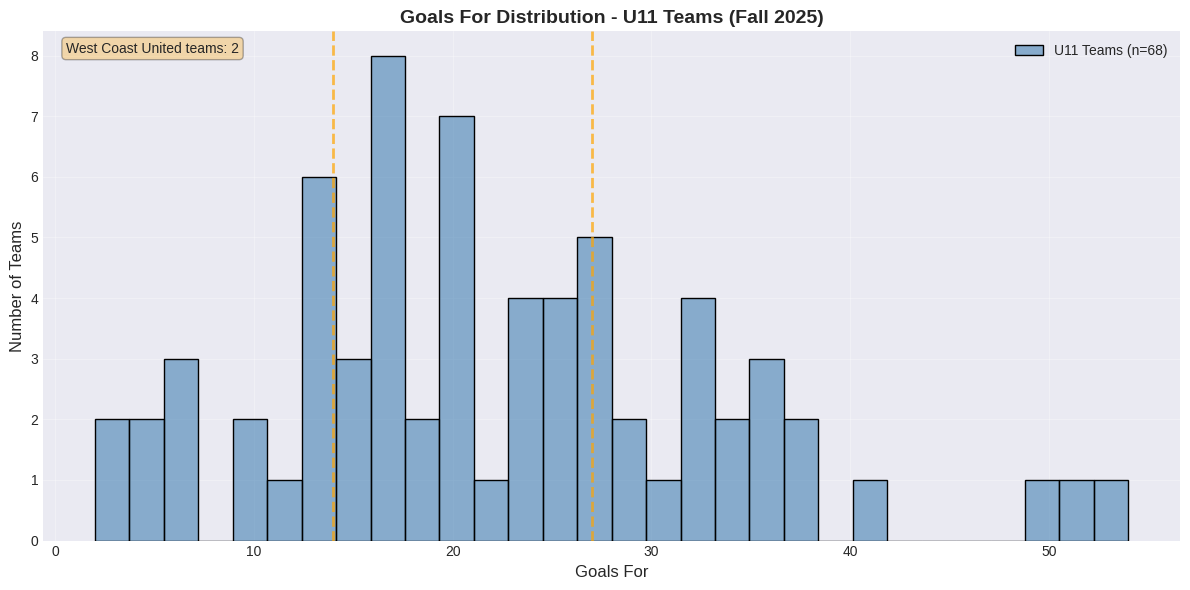

In [ ]:
# Goals For (Points For) distribution for U11 teams
if len(df_u11) > 0:
    plot_distribution_with_highlights(
        df_u11, 
        'goals_for', 
        'Goals For Distribution - U11 Teams (Fall 2025)',
        'Goals For',
        target_team_name=target_team_name_found,
        wcu_teams=wcu_u11,
        subset_label="U11 Teams"
    )
    plt.show()


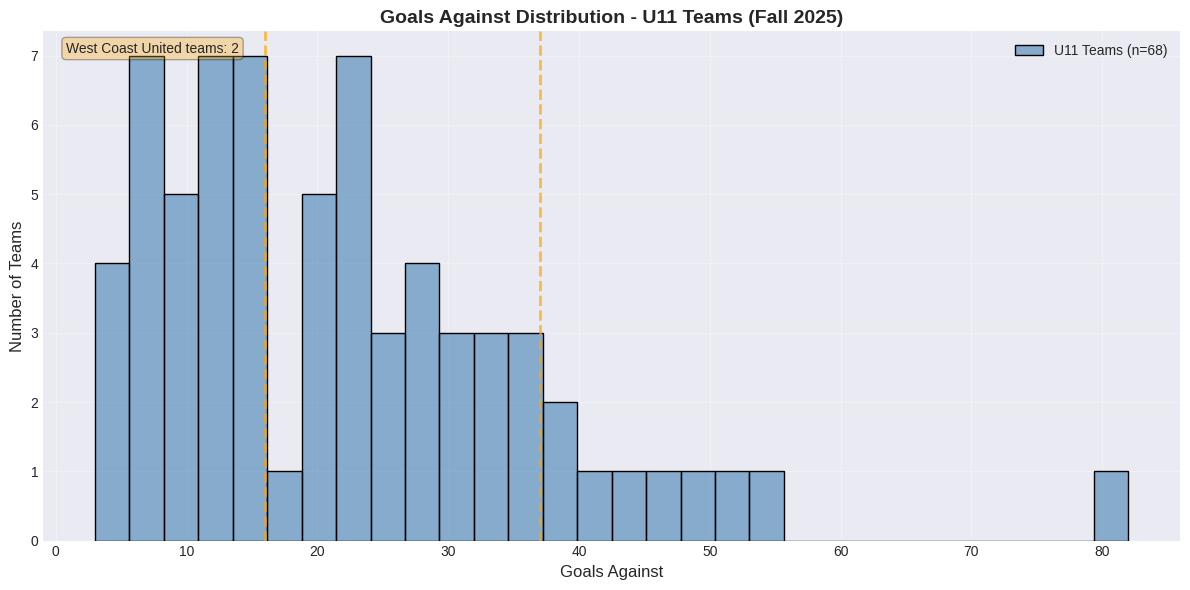

In [ ]:
# Goals Against (Points Against) distribution for U11 teams
if len(df_u11) > 0:
    plot_distribution_with_highlights(
        df_u11, 
        'goals_against', 
        'Goals Against Distribution - U11 Teams (Fall 2025)',
        'Goals Against',
        target_team_name=target_team_name_found,
        wcu_teams=wcu_u11,
        subset_label="U11 Teams"
    )
    plt.show()


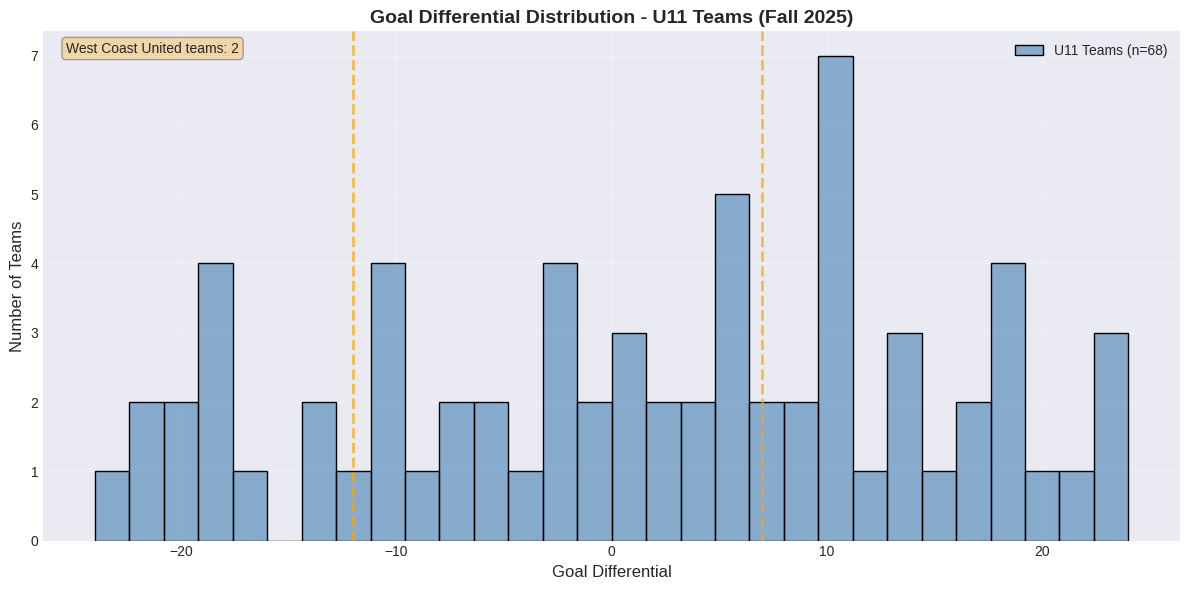

In [ ]:
# Goal Differential distribution for U11 teams
if len(df_u11) > 0:
    plot_distribution_with_highlights(
        df_u11, 
        'goal_differential', 
        'Goal Differential Distribution - U11 Teams (Fall 2025)',
        'Goal Differential',
        target_team_name=target_team_name_found,
        wcu_teams=wcu_u11,
        subset_label="U11 Teams"
    )
    plt.show()


In [ ]:
# Points distribution for U11 teams
if len(df_u11) > 0:
    plot_distribution_with_highlights(
        df_u11, 
        'points', 
        'Points Distribution - U11 Teams (Fall 2025)',
        'Points',
        target_team_name=target_team_name_found,
        wcu_teams=wcu_u11,
        subset_label="U11 Teams"
    )
    plt.show()


## Distribution Analysis: ALL Teams in Fall 2025

Compare the target team to ALL teams in Fall 2025 (all age groups).


In [ ]:
# Get target team data from all teams - ALWAYS use exact team from database first
target_team_all = None
target_team_name_all = None

# First, try to use the exact team found in Cell 16
if 'target_team_season' in locals() and target_team_season:
    target_team_name_all = target_team_season.team_name
    print(f"Using target team from database: {target_team_name_all}")
    
    # Verify the team exists in the DataFrame with exact match
    if 'df_fall_2025' in locals() and len(df_fall_2025) > 0:
        exact_match = df_fall_2025[df_fall_2025['team_name'] == target_team_name_all]
        if len(exact_match) > 0:
            target_team_all = exact_match.iloc[0]
            print(f"  Found in Fall 2025 DataFrame with exact match")
            print(f"  Data: {target_team_all['goals_for']}GF / {target_team_all['goals_against']}GA / {target_team_all['goal_differential']}GD")
        else:
            print(f"  Warning: Team not found in Fall 2025 DataFrame")
elif 'df_fall_2025' in locals() and len(df_fall_2025) > 0:
    # Fallback: Try to find in DataFrame with exact match first
    target_mask_all = df_fall_2025['team_name'].str.contains('west coast united 15b green rp', case=False, na=False)
    if not target_mask_all.any():
        # Try partial match as last resort
        target_mask_all = df_fall_2025['team_name'].str.contains('west coast', case=False, na=False) & \
                          df_fall_2025['team_name'].str.contains('15b', case=False, na=False) & \
                          df_fall_2025['team_name'].str.contains('green', case=False, na=False)
    if target_mask_all.any():
        target_team_all = df_fall_2025[target_mask_all].iloc[0]
        target_team_name_all = target_team_all['team_name']

if 'df_fall_2025' in locals():
    print(f"\nTarget team for visualization: {target_team_name_all}")
    print(f"Total teams in Fall 2025: {len(df_fall_2025)}")
    if 'df_wcu' in locals():
        print(f"West Coast United teams: {len(df_wcu)}")
else:
    print("Fall 2025 data not loaded. Please run the previous cells first.")


In [ ]:
# Goals For distribution for ALL teams
if len(df_fall_2025) > 0:
    plot_distribution_with_highlights(
        df_fall_2025, 
        'goals_for', 
        'Goals For Distribution - ALL Teams (Fall 2025)',
        'Goals For',
        target_team_name=target_team_name_all,
        wcu_teams=df_wcu,
        subset_label="All Teams"
    )
    plt.show()


In [ ]:
# Goals Against distribution for ALL teams
if len(df_fall_2025) > 0:
    plot_distribution_with_highlights(
        df_fall_2025, 
        'goals_against', 
        'Goals Against Distribution - ALL Teams (Fall 2025)',
        'Goals Against',
        target_team_name=target_team_name_all,
        wcu_teams=df_wcu,
        subset_label="All Teams"
    )
    plt.show()


In [ ]:
# Goal Differential distribution for ALL teams
if len(df_fall_2025) > 0:
    plot_distribution_with_highlights(
        df_fall_2025, 
        'goal_differential', 
        'Goal Differential Distribution - ALL Teams (Fall 2025)',
        'Goal Differential',
        target_team_name=target_team_name_all,
        wcu_teams=df_wcu,
        subset_label="All Teams"
    )
    plt.show()


In [ ]:
# Points distribution for ALL teams
if len(df_fall_2025) > 0:
    plot_distribution_with_highlights(
        df_fall_2025, 
        'points', 
        'Points Distribution - ALL Teams (Fall 2025)',
        'Points',
        target_team_name=target_team_name_all,
        wcu_teams=df_wcu,
        subset_label="All Teams"
    )
    plt.show()


## Summary Statistics

Compare the target team's performance to U11 and all teams.


In [ ]:
# Create summary comparison
# Use exact team name from database if available
target_name_for_stats = None
if 'target_team_season' in locals() and target_team_season:
    target_name_for_stats = target_team_season.team_name
elif 'target_team_name_found' in locals() and target_team_name_found:
    target_name_for_stats = target_team_name_found

if target_name_for_stats and 'df_u11' in locals() and len(df_u11) > 0:
    # Use exact match first
    target_u11 = df_u11[df_u11['team_name'] == target_name_for_stats]
    if len(target_u11) == 0:
        # Fallback to contains
        target_u11 = df_u11[df_u11['team_name'].str.contains(target_name_for_stats, case=False, na=False)]
    if len(target_u11) > 0:
        target_row = target_u11.iloc[0]
        
        print("=" * 80)
        print(f"TARGET TEAM: {target_row['team_name']}")
        print(f"Division: {target_row['division']}")
        print("=" * 80)
        
        metrics = ['goals_for', 'goals_against', 'goal_differential', 'points']
        
        comparison_data = []
        for metric in metrics:
            if metric not in target_row.index:
                continue
                
            target_val = target_row[metric]
            u11_mean = df_u11[metric].mean() if len(df_u11) > 0 and metric in df_u11.columns else 0
            u11_percentile = (df_u11[metric] <= target_val).sum() / len(df_u11) * 100 if len(df_u11) > 0 and metric in df_u11.columns else 0
            
            # Check if df_fall_2025 exists and has data
            if 'df_fall_2025' in locals() and len(df_fall_2025) > 0 and metric in df_fall_2025.columns:
                all_mean = df_fall_2025[metric].mean()
                all_percentile = (df_fall_2025[metric] <= target_val).sum() / len(df_fall_2025) * 100
            else:
                all_mean = 0
                all_percentile = 0
            
            comparison_data.append({
                'Metric': metric.replace('_', ' ').title(),
                'Target Value': target_val,
                'U11 Mean': f"{u11_mean:.1f}",
                'U11 Percentile': f"{u11_percentile:.1f}%",
                'All Teams Mean': f"{all_mean:.1f}",
                'All Teams Percentile': f"{all_percentile:.1f}%",
            })
        
        if comparison_data:
            df_comparison = pd.DataFrame(comparison_data)
            print("\nComparison Summary:")
            print(df_comparison.to_string(index=False))
        
        print("\n" + "=" * 80)
        print("West Coast United Teams Summary:")
        print("=" * 80)
        if 'df_wcu' in locals() and len(df_wcu) > 0:
            required_cols = ['team_name', 'division', 'goals_for', 'goals_against', 'goal_differential', 'points']
            available_cols = [col for col in required_cols if col in df_wcu.columns]
            if available_cols:
                print(df_wcu[available_cols].to_string(index=False))
            else:
                print("No West Coast United teams found in Fall 2025")
        else:
            print("No West Coast United teams found in Fall 2025")
else:
    print("Target team data not available. Please run the previous cells to load team data.")
